In [1]:
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

Using TensorFlow backend.


In [2]:
# Preprocessing

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

In [3]:
# Set the dimensions of the noise
z_dim = 100

In [4]:
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

g = Sequential()
g.add(Dense(256, input_dim=z_dim))
g.add(Activation('relu'))
g.add(Dense(512))
g.add(Dense(1024))
g.add(Dense(784, activation='sigmoid'))  
g.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

d = Sequential()
d.add(Dense(1024, input_dim=784))
d.add(Activation('relu'))
d.add(Dropout(0.3))
d.add(Dense(512))
d.add(Dropout(0.3))
d.add(Dense(256))
d.add(Dropout(0.3))
d.add(Dense(1, activation='sigmoid'))  # Values between 0 and 1
d.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

d.trainable = False
inputs = Input(shape=(z_dim, ))
hidden = g(inputs)
output = d(hidden)
gan = Model(inputs, output)
gan.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [5]:
def plot_loss(losses):
    d_loss = [v[0] for v in losses["D"]]
    g_loss = [v[0] for v in losses["G"]]
    
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def plot_generated(n_ex=10, dim=(1, 10), figsize=(12, 2)):
    noise = np.random.normal(0, 1, size=(n_ex, z_dim))
    generated_images = g.predict(noise)
    generated_images = generated_images.reshape(n_ex, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [6]:
# Set up a vector (dict) to store the losses
losses = {"D":[], "G":[]}

def train(epochs=1, plt_frq=1, BATCH_SIZE=128):
    batchCount = int(X_train.shape[0] / BATCH_SIZE)
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batchCount)
    
    for e in tqdm_notebook(range(1, epochs+1)):
        if e == 1 or e%plt_frq == 0:
            print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batchCount):  # tqdm_notebook(range(batchCount), leave=False):
            # Create a batch by drawing random index numbers from the training set
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)]
            # Create noise vectors for the generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            
            # Generate the images from the noise
            generated_images = g.predict(noise)
            X = np.concatenate((image_batch, generated_images))
            # Create labels
            y = np.zeros(2*BATCH_SIZE)
            y[:BATCH_SIZE] = 0.9  # One-sided label smoothing

            # Train discriminator on generated images
            d.trainable = True
            d_loss = d.train_on_batch(X, y)

            # Train generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            y2 = np.ones(BATCH_SIZE)
            d.trainable = False
            g_loss = gan.train_on_batch(noise, y2)
            
        # Only store losses from final batch of epoch
        losses["D"].append(d_loss)
        losses["G"].append(g_loss)

        # Update the plots
        if e == 1 or e%plt_frq == 0:
            plot_generated()
    plot_loss(losses)

Epochs: 200
Batch size: 128
Batches per epoch: 468


--------------- Epoch 1 ---------------
Instructions for updating:
Use tf.cast instead.


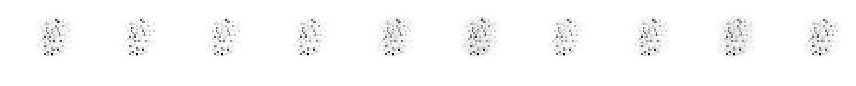

--------------- Epoch 10 ---------------


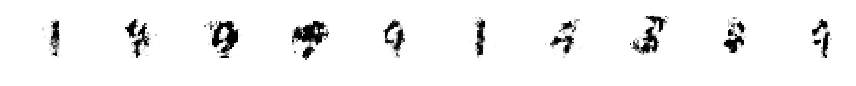

--------------- Epoch 20 ---------------


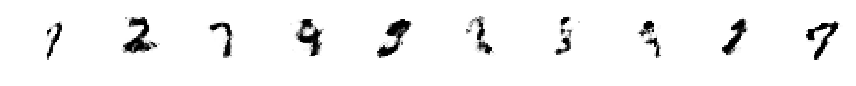

--------------- Epoch 30 ---------------


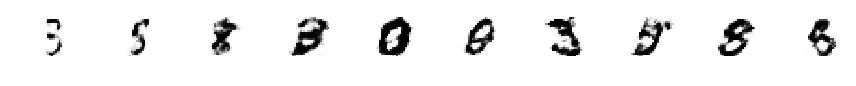

--------------- Epoch 40 ---------------


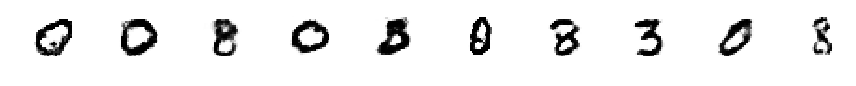

--------------- Epoch 50 ---------------


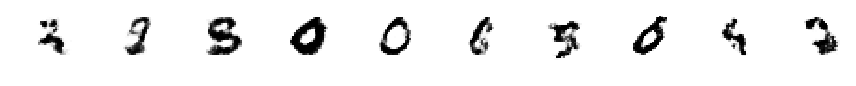

--------------- Epoch 60 ---------------


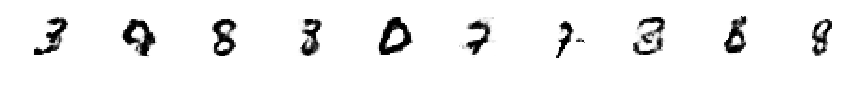

--------------- Epoch 70 ---------------


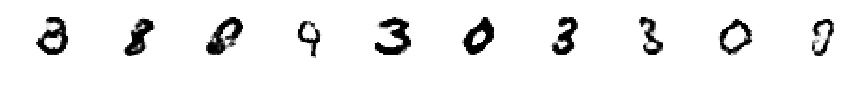

--------------- Epoch 80 ---------------


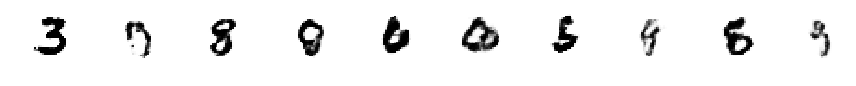

--------------- Epoch 90 ---------------


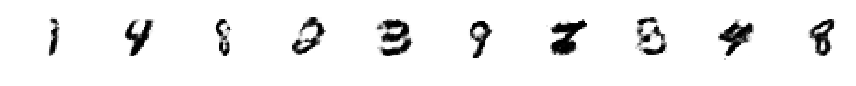

--------------- Epoch 100 ---------------


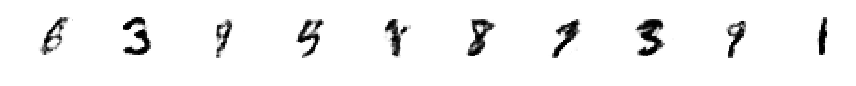

--------------- Epoch 110 ---------------


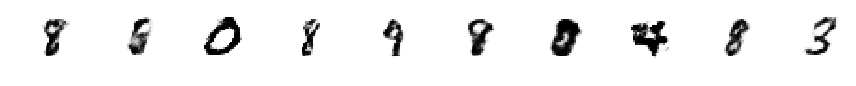

--------------- Epoch 120 ---------------


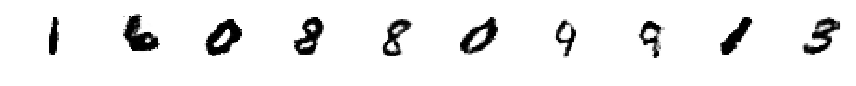

--------------- Epoch 130 ---------------


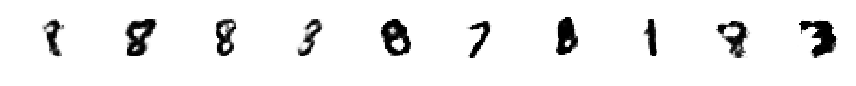

--------------- Epoch 140 ---------------


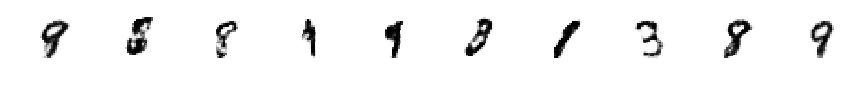

--------------- Epoch 150 ---------------


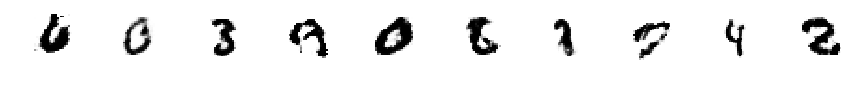

--------------- Epoch 160 ---------------


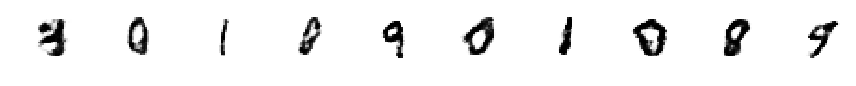

--------------- Epoch 170 ---------------


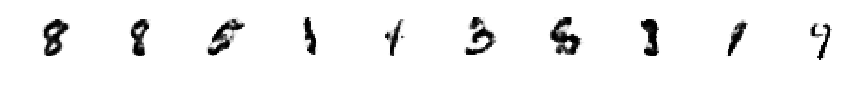

--------------- Epoch 180 ---------------


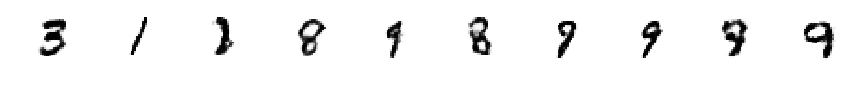

--------------- Epoch 190 ---------------


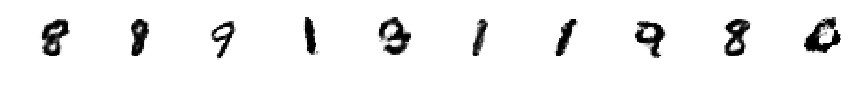

--------------- Epoch 200 ---------------


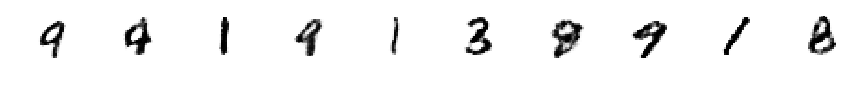

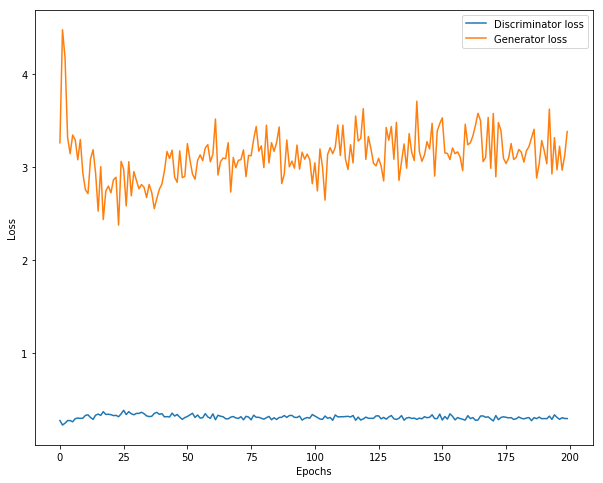

In [7]:
train(epochs=200, plt_frq=10, BATCH_SIZE=128)

Saved model to disk


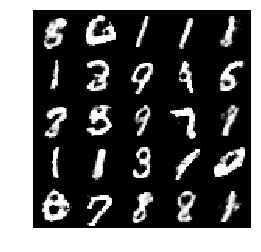

In [32]:
# serialize model to JSON
model_json = g.to_json()
with open("generator.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
g.save_weights("generator.h5")
print("Saved model to disk")

# Generate images
number = 25
np.random.seed(number)
h = w = 28
num_gen = 25

z = np.random.normal(size=[num_gen, z_dim])
generated_images = g.predict(z)

# plot of generation
n = np.sqrt(num_gen).astype(np.int32)
I_generated = np.empty((h*n, w*n))
for i in range(n):
    for j in range(n):
        I_generated[i*h:(i+1)*h, j*w:(j+1)*w] = generated_images[i*n+j, :].reshape(28, 28)

plt.figure(figsize=(4, 4))
plt.axis("off")
plt.imshow(I_generated, cmap='gray')
plt.savefig('pic/seed{}.png'.format(number))
plt.show()